In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from neo import SpikeTrain

import ast
import h5py
import json
import os
import sys
import random

In [2]:
# Import helper
sys.path.append("../")

from helpers import helper_funcs
# Reloads if changes happens
from importlib import reload
reload(helper_funcs)

<module 'helpers.helper_funcs' from 'C:\\Users\\hakon\\Skole\\NMBU_8\\Masteroppgave\\masteroppgave-data-2023\\figures\\..\\helpers\\helper_funcs.py'>

In [3]:
# Set style todo: update?
sns.set(context="paper", font_scale=1.5, style='darkgrid')

# Save plot
SAVE_PLOT = False

In [4]:
# Plots prior disitribution (uniform)
def plot_prior(min_val, max_val, x_label, obs_value, ax, N=10000, solid_line=False, color=None, fontsize=11, set_legend=True):
    """Plots prior distribution of the first simulation (uniform)"""
    # Min and max value of synapse weight (from github simulation)

    scale = np.abs(min_val - max_val) * 0.2

    # Distribution calculator
    # todo remove: Distributions (ee = exhitatory to exhitatory, ie = exhitatory to inhibitory etc.)
    distribution = stats.uniform(loc=min_val, scale=(max_val - min_val))

    # weight_values to evaluate distribution
    xs = np.linspace(min_val - scale, max_val + scale, num=N)

    # Make different colors
    if color:
        ax.plot(xs, distribution.pdf(xs), color=color)
        ax.fill_between(xs, distribution.pdf(xs), color=color, alpha=.5)
        ax.set_xlabel(x_label)
        
    elif x_label[-1].lower() == "e":  # make positive values same color'
        ax.plot(xs, distribution.pdf(xs))
        ax.fill_between(xs, distribution.pdf(xs), alpha=.5)
        ax.set_xlabel(x_label)
    else:
        ax.plot(xs, distribution.pdf(xs), color="C1")
        ax.fill_between(xs, distribution.pdf(xs), color="C1", alpha=.5)
        ax.set_xlabel(x_label)
        
    # Plot true observation
    y_coord = np.max(distribution.pdf(obs_value))
    if solid_line:
        ax.vlines(x=obs_value, ymin=0, ymax=y_coord, ls="-", color="black", label=rf"$\theta_{{true}}$: {obs_value:.3}")
    else:
        ax.vlines(x=obs_value, ymin=0, ymax=y_coord, ls="--", color="black", label=rf"$\theta_{{true}}$: {obs_value:.3}")
    
    if set_legend:
        ax.legend(loc="upper left", fontsize=fontsize)

In [5]:
# Parameter names
param_names = ["g_ee", "g_ie","g_ei", "g_ii"]
summary_stat_names = ["mean_firing_rate_inhibitory",
                      "mean_firing_rate_excitatory",
                      "fanofactor_inhibitory",
                      "fanofactor_excitatory",
                      "mean_interspike_interval_inhibitory",
                      "mean_interspike_interval_excitatory",
                      "mean_cv_inhibitory",
                      "mean_cv_excitatory"]

# For plotting of uniform priors
min_max_dict = {"e": {"min_value": 0.5, "max_value": 2.0}, 
                "i": {"min_value": -16.0, "max_value": -2.25}}

In [6]:
# Base observation
df_obs_base = helper_funcs.load_file("../2pop/data/obs/2pop_observation_base")
obs_hist_base = helper_funcs.load_file("../2pop/data/obs/2pop_observation_histogram_base")

# Samples used to create final observation metrics
df_obs_samples = helper_funcs.load_file("../2pop/data/obs/2pop_observation_samples")
obs_hist_samples = helper_funcs.load_file("../2pop/data/obs/2pop_observation_histogram_samples")

# Final observation
df_obs = helper_funcs.load_file("../2pop/data/2pop_observation")
obs_hist = helper_funcs.load_file("../2pop/data/2pop_observation_histogram")

In [7]:
df_sim_0 = helper_funcs.load_file("../2pop/data/sim_0/2pop_simulations_0")
hist_sim_0 = helper_funcs.load_file("../2pop/data/sim_0/2pop_simulations_histogram_0")

#### Raster plot

#### Summary statistics plots

In [8]:
# Get df corresponding to histogram samlple
closest_distance_idx = helper_funcs.load_file("../2pop/data/2pop_closest_distance_idx")

df_closest_histogram_sample = pd.DataFrame(df_obs_samples.iloc[closest_distance_idx].values.reshape(1, -1), columns=df_obs_samples.iloc[closest_distance_idx].index)

df_closest_histogram_sample

,g_ee,g_ei,g_ie,g_ii,mean_firing_rate_inhibitory,mean_firing_rate_excitatory,fanofactor_inhibitory,fanofactor_excitatory,mean_interspike_interval_inhibitory,mean_interspike_interval_excitatory,mean_cv_inhibitory,mean_cv_excitatory
0,1.086137,-5.909711,1.033216,-7.790382,0.014205,0.03545,2.322489,1.042736,68.655221,28.173492,1.5157,0.89522


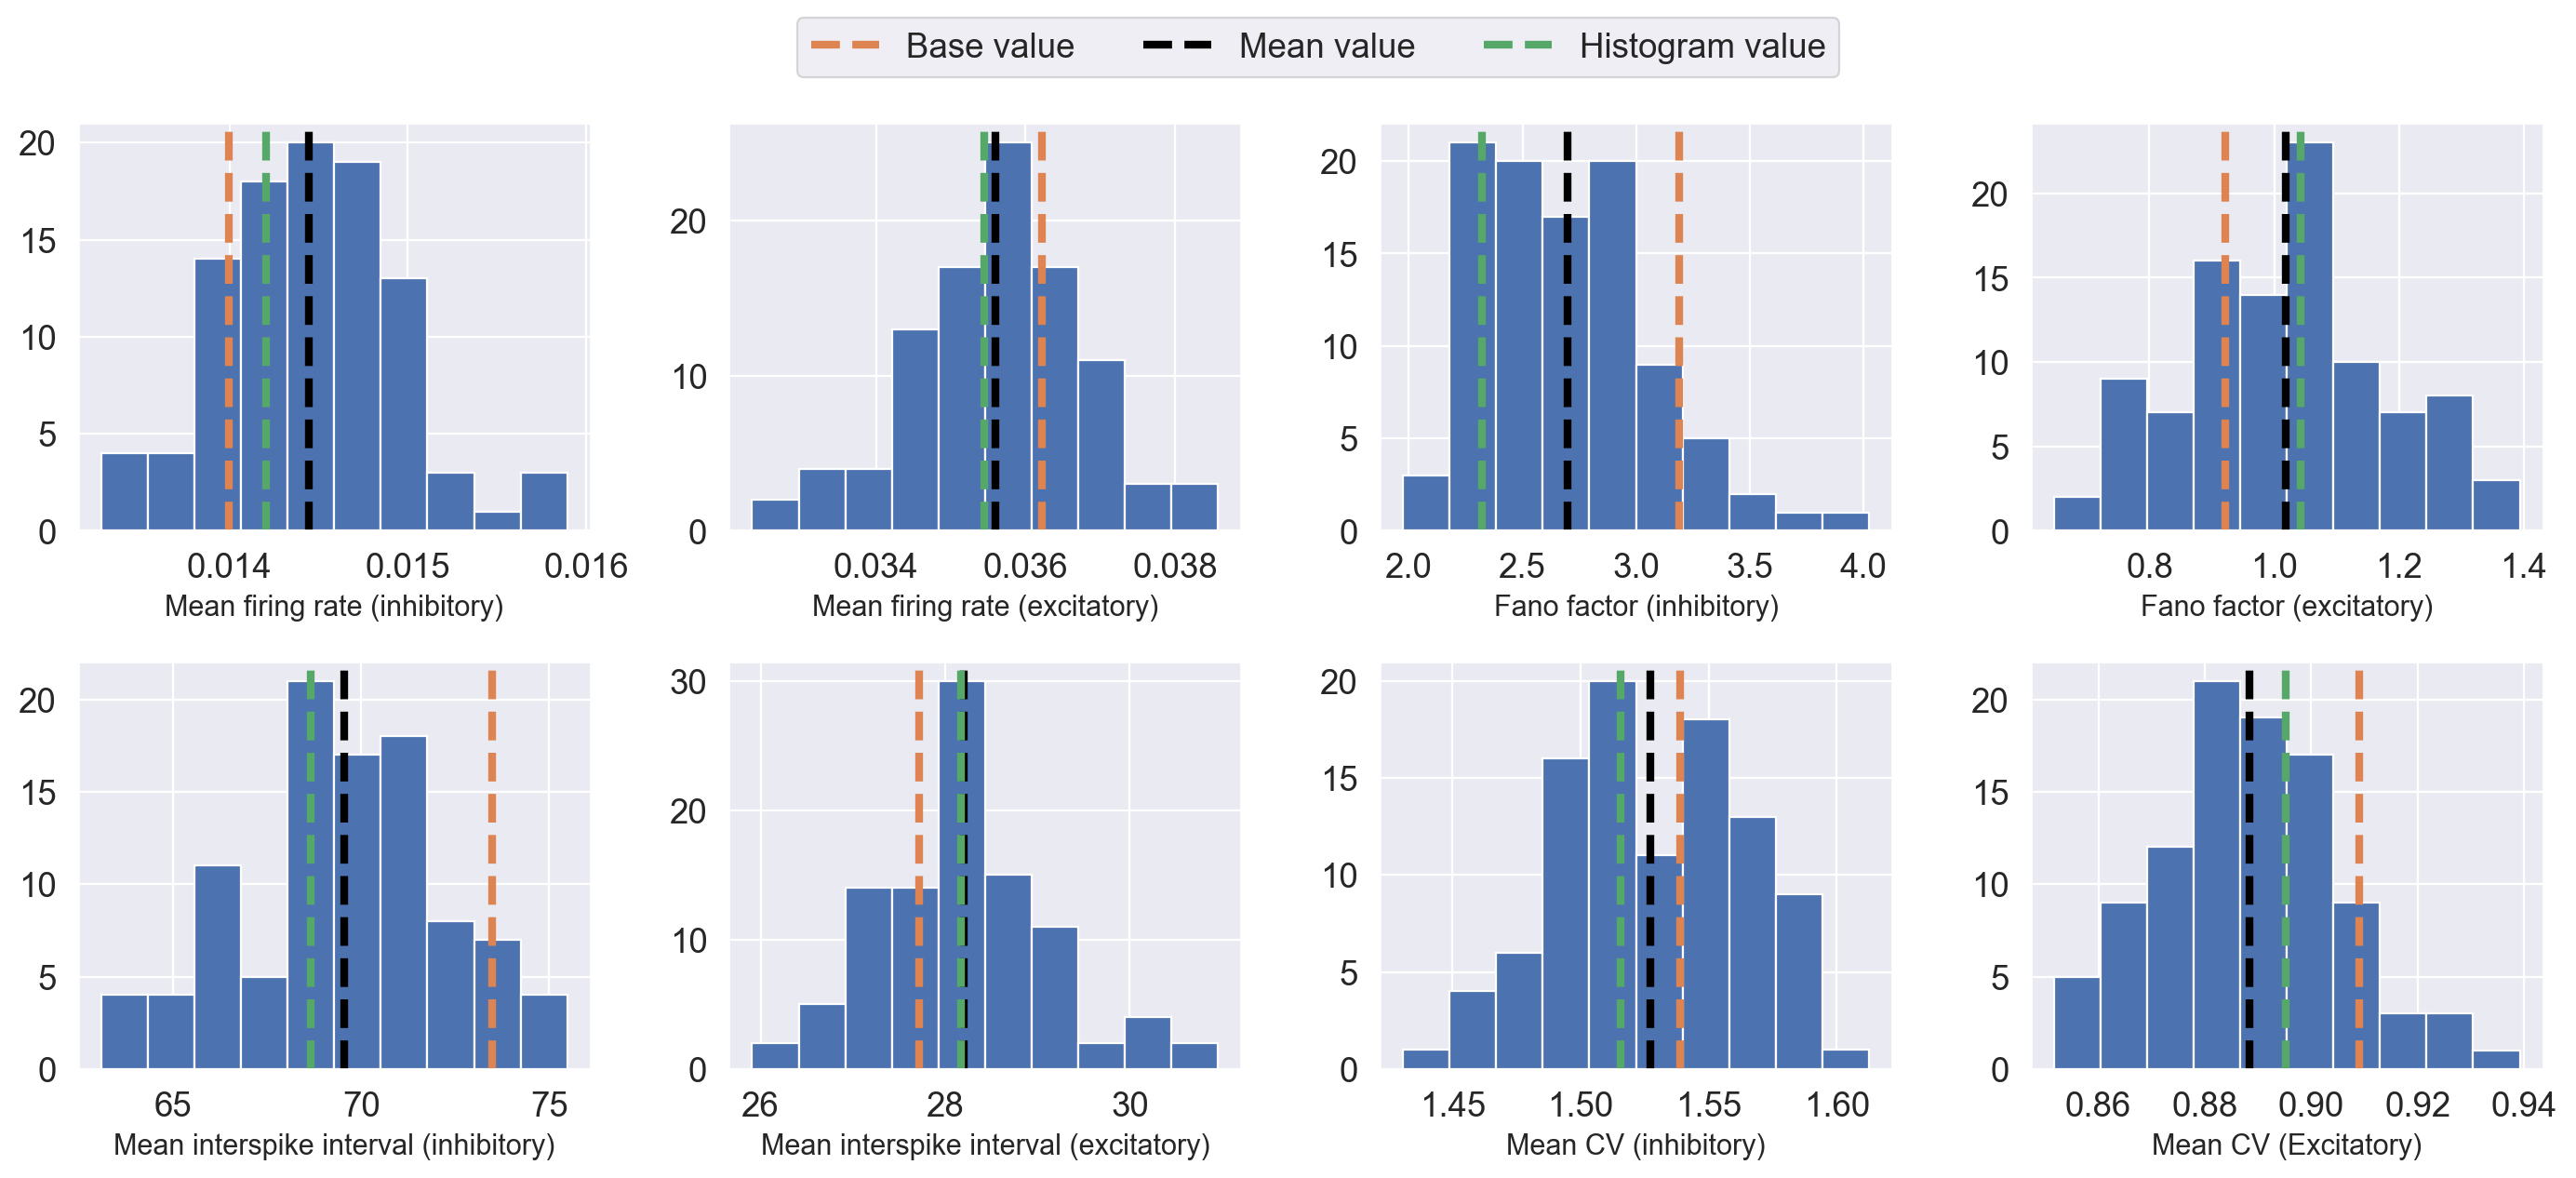

In [9]:
cols = 4
rows = 2

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_obs.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (Excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].hist(df_obs_samples[sumstat_names[sumstat_idx]])
        # set the vertical line denoting mean
        ax[row, col].axvline(x=float(df_obs_base[sumstat_names[sumstat_idx]]), color="C1", ls="--", lw=3.0,
                     label=f"Base value", )
        ax[row, col].axvline(x=float(df_obs[sumstat_names[sumstat_idx]]), color="black", ls="--", lw=3.0,
                             label="Mean value")
        ax[row, col].axvline(x=float(df_closest_histogram_sample[sumstat_names[sumstat_idx]]), color="C2", ls="--", lw=3.0,
             label=f"Histogram value", )
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]], size=11)
        #ax[row, col].get_label().remove()
        
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1
        
# Set label
plt.tight_layout()
ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.15, 1.3), ncol=3)

if SAVE_PLOT:
    save_path = "./for_thesis/data/obs_histogram_with_value_lines.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

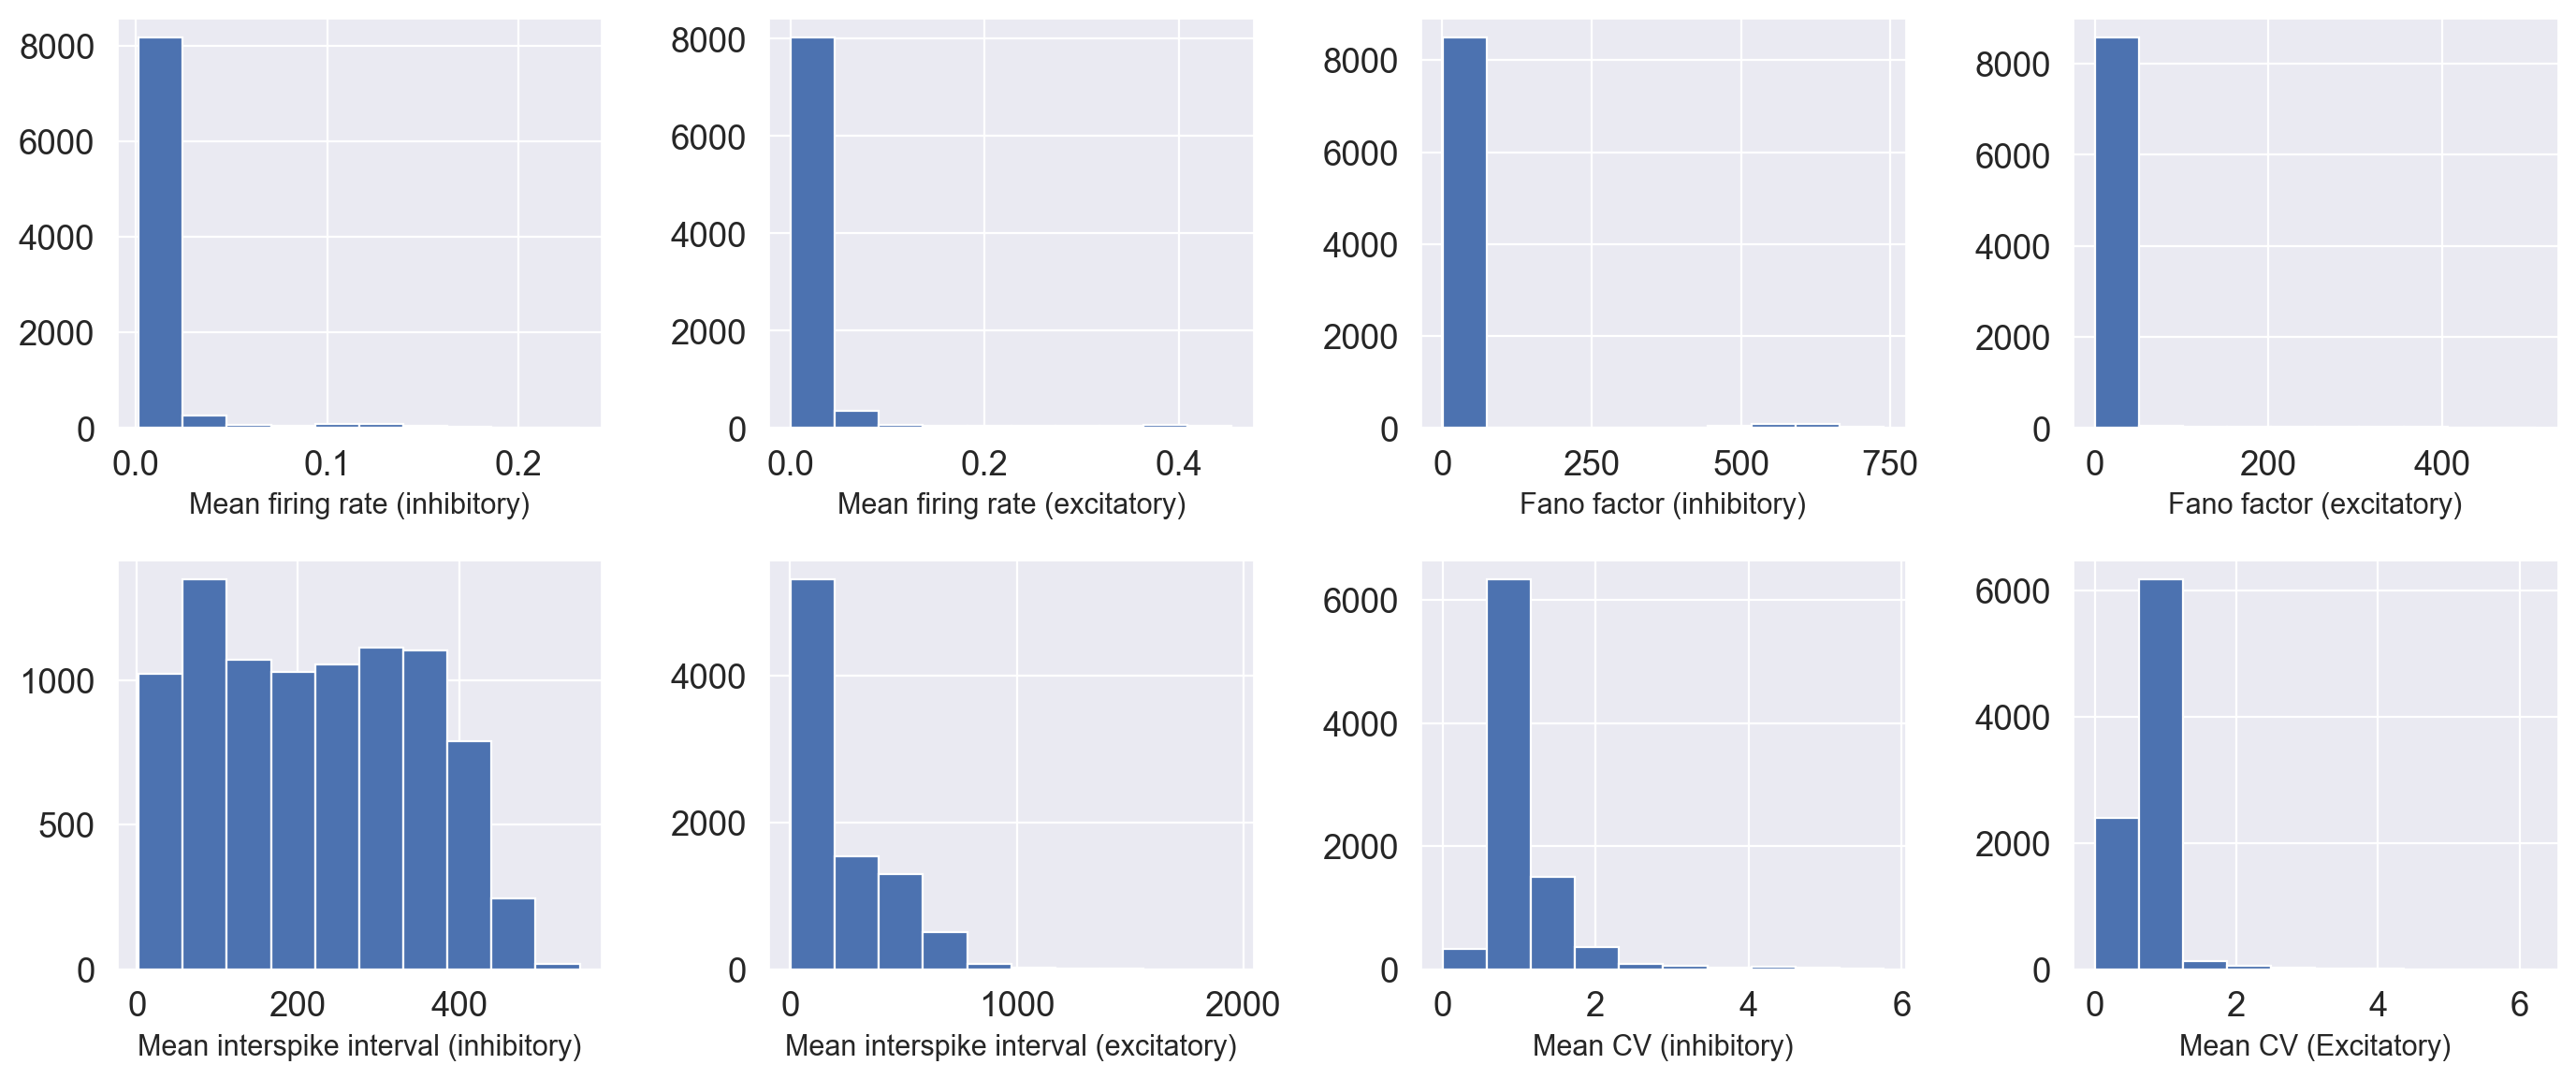

In [10]:
cols = 4
rows = 2

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_sim_0.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (Excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].hist(df_sim_0[sumstat_names[sumstat_idx]])
        # set the vertical line denoting mean
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]], size=11)
        #ax[row, col].get_label().remove()
        
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1
        
# Set label
plt.tight_layout()
#ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.85, 1.3), ncol=3)

In [11]:
# Remove samples with std < -2 and > 2
masks = (stats.zscore(df_sim_0[summary_stat_names]) > -2).all(axis=1) & \
               (stats.zscore(df_sim_0[summary_stat_names]) < 2).all(axis=1)

drop_index = np.where(masks.values == False)[0]

In [12]:
df_sim_0_masked = df_sim_0.drop(axis=0, index=drop_index)

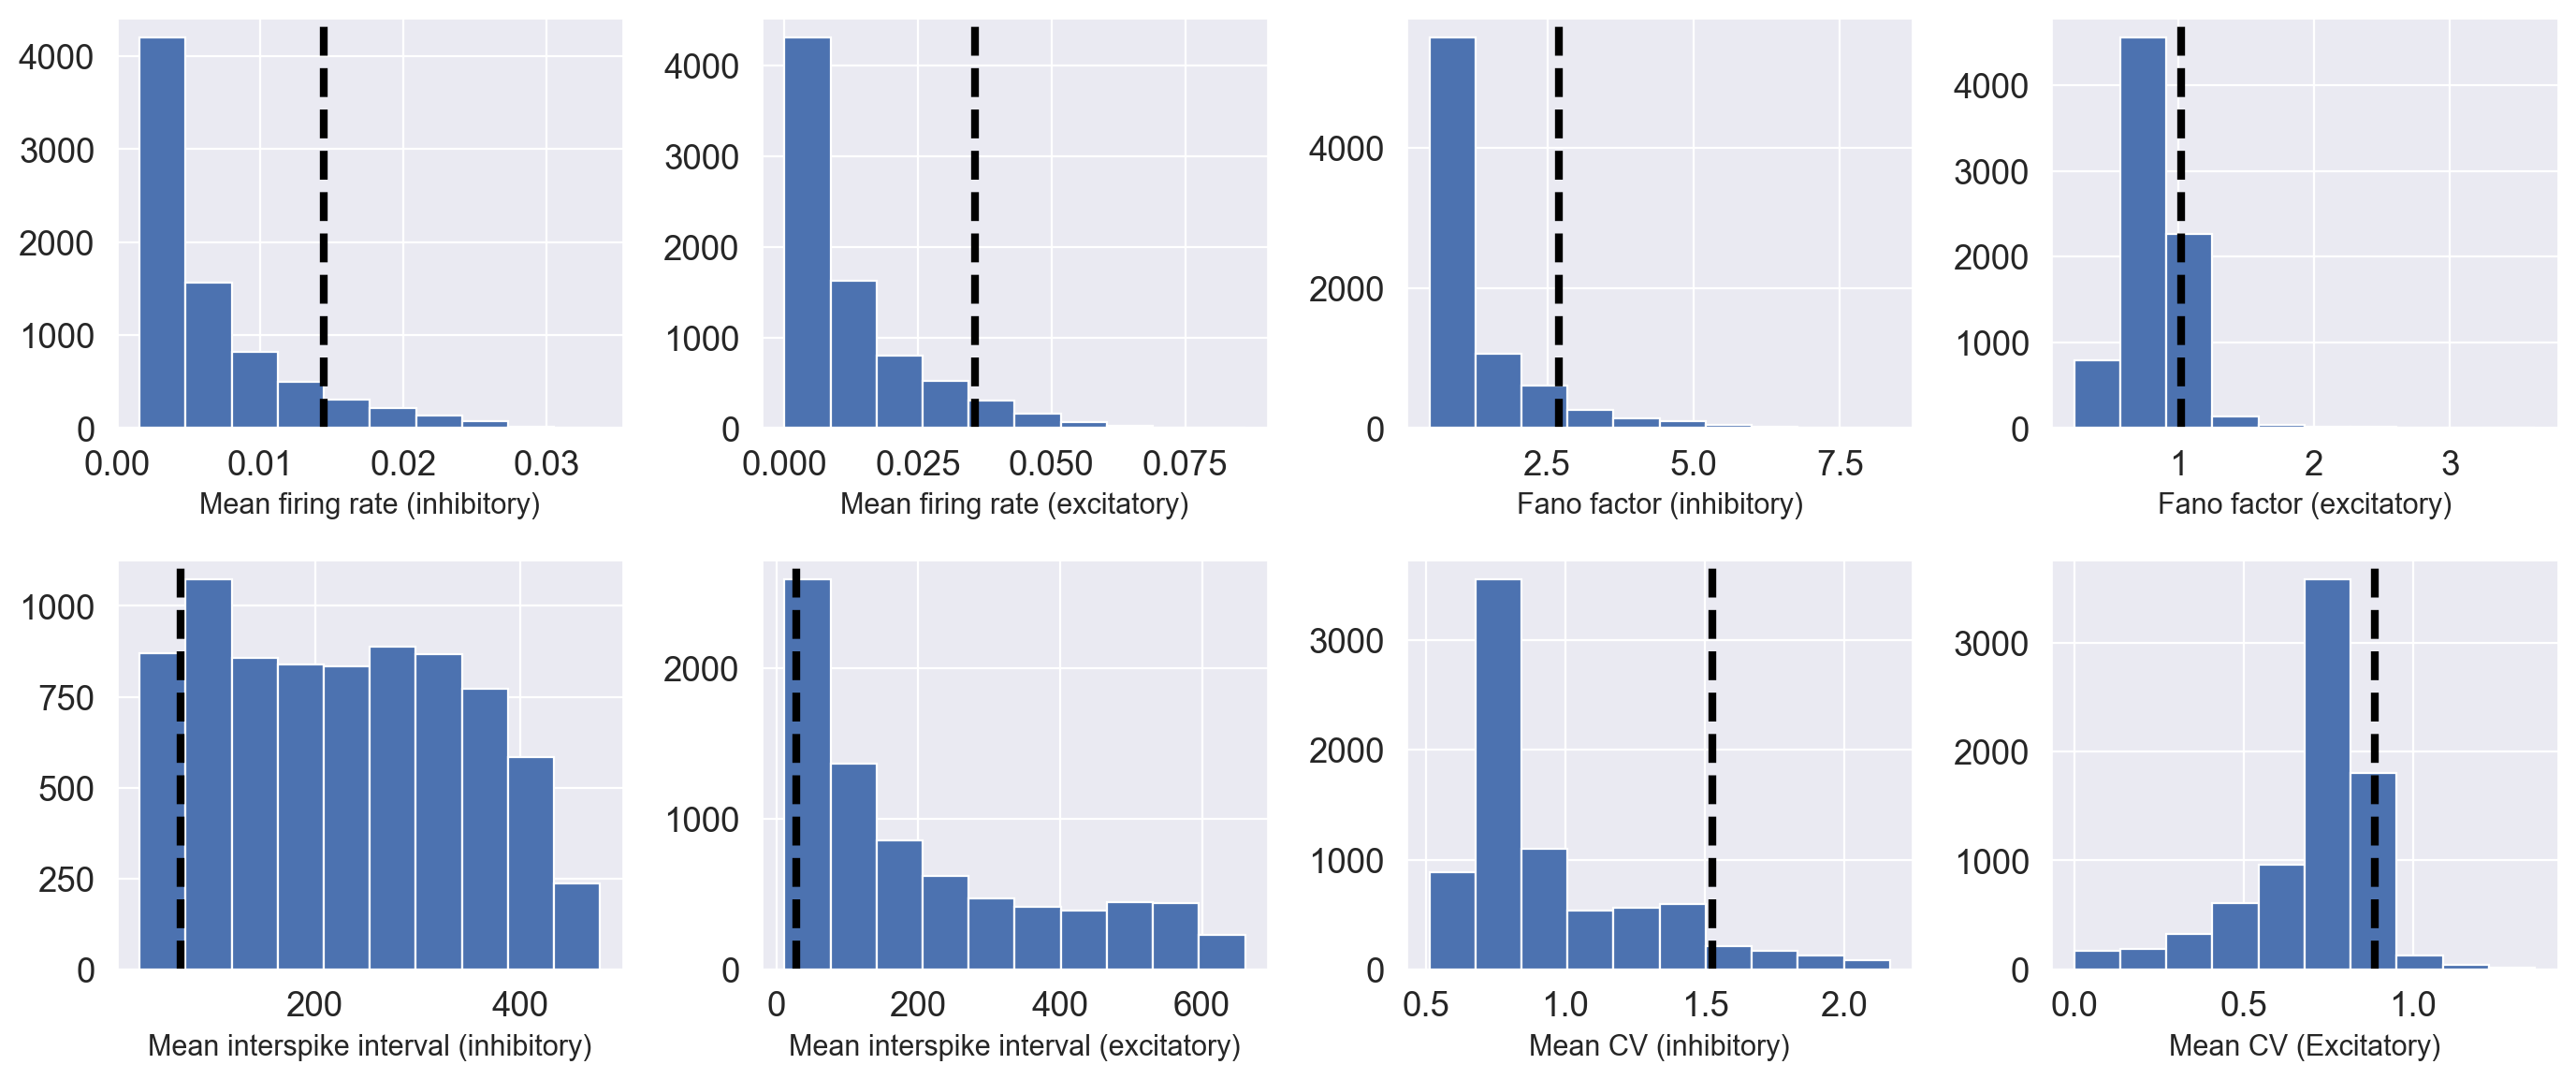

In [13]:
cols = 4
rows = 2

fig, ax = plt.subplots(rows, cols, figsize=(14, 6), dpi=200)
sumstat_names = list(df_sim_0_masked.columns[4:])
#param_names = list(df_obs.columns[:4])

xlabels  = {"mean_firing_rate_inhibitory": "Mean firing rate (inhibitory)", 
            "mean_firing_rate_excitatory": "Mean firing rate (excitatory)", 
            "fanofactor_inhibitory": "Fano factor (inhibitory)", 
            "fanofactor_excitatory": "Fano factor (excitatory)", 
            "mean_interspike_interval_inhibitory": "Mean interspike interval (inhibitory)", 
            "mean_interspike_interval_excitatory": "Mean interspike interval (excitatory)", 
            "mean_cv_inhibitory": "Mean CV (inhibitory)", 
            "mean_cv_excitatory": "Mean CV (Excitatory)"}

sumstat_idx = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].hist(df_sim_0_masked[sumstat_names[sumstat_idx]])
        
        ax[row, col].set_xlabel(xlabels[sumstat_names[sumstat_idx]], size=11)
        
        # Set observation v line
        ax[row, col].axvline(x=float(df_obs[sumstat_names[sumstat_idx]]), color="black", ls="--", lw=3.0)
        
        ax[row, col].ticklabel_format(style="plain")
        
        sumstat_idx += 1
        
# Set label
plt.tight_layout()
#ax[0, 1].legend(loc="upper center", bbox_to_anchor=(0.85, 1.3), ncol=3)

if SAVE_PLOT:
    save_path = "./for_thesis/data/sim_0_histogram_with_adjusted_z_score.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

#### Spike count histogram

In [14]:
# Get a color palette
palette = sns.color_palette("viridis", len(obs_hist_samples))

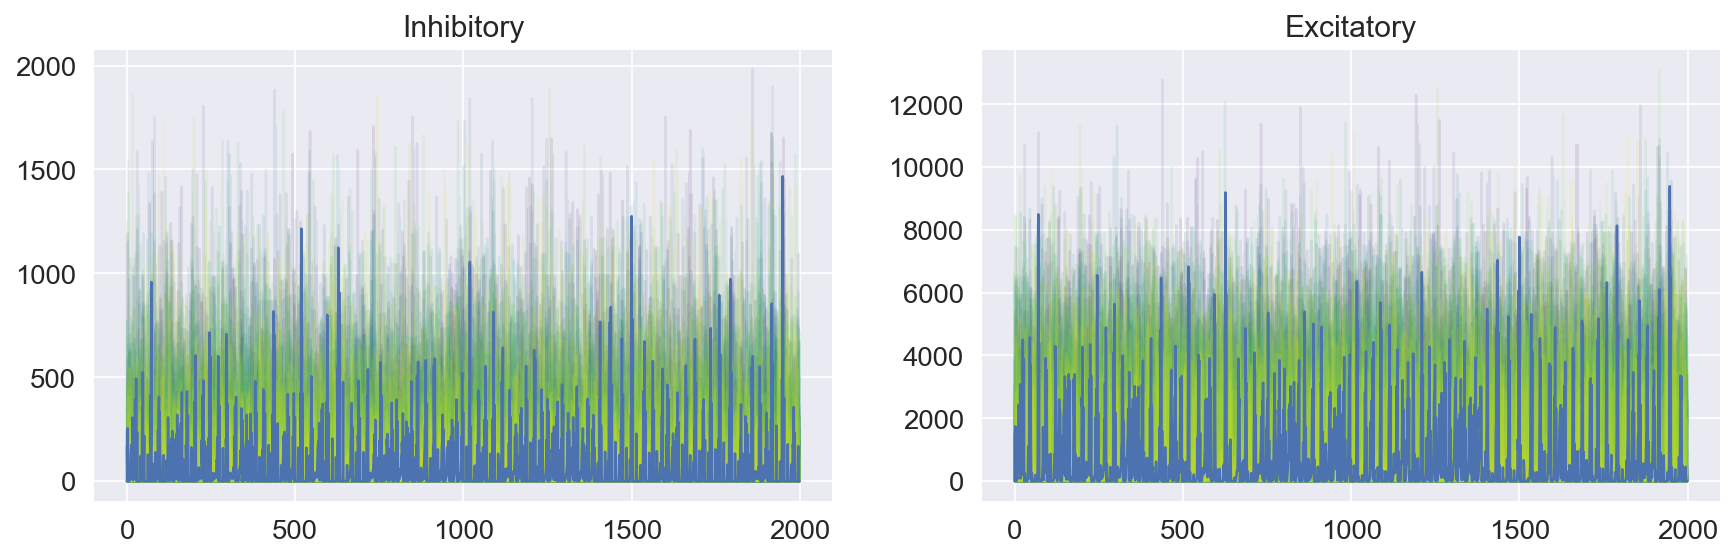

In [15]:
# With base
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=150)

# Plot histogram obs sample variation vs final histogram obs
for i in range(len(obs_hist_samples)):
    ax[0].plot(obs_hist_samples[i][1], alpha=0.1, color=palette[i])
    
    ax[1].plot(obs_hist_samples[i][0], alpha=0.1, color=palette[i])

ax[0].set_title("Inhibitory")
ax[0].plot(obs_hist[1], color="C0")

ax[1].set_title("Excitatory")
ax[1].plot(obs_hist[0], color="C0")

if SAVE_PLOT:
    save_path = "./for_thesis/data/final_histogram_vs_histogram_samples.pdf"
    print(f"Saving to file: {save_path}")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")

#### Raster plot

In [16]:
def create_rasterplot(spiketrain_sample, title, ax, color="black", start=0, stop=10, fontsize=12, linewidth=1, dpi=120):
    # E.g.: spiketrain_sample = spiketrains_L4E["sample_2"]
    
    
    spike_list = []
    spike_names = []
    
    for neuron_num in range(start, stop):
        temp_spike = SpikeTrain(spiketrain_sample[neuron_num], t_stop=5200, units="ms")
        spike_list.append(temp_spike.magnitude)
        
        # Generate name for plotting
        temp_name = f"Spiketrain_{neuron_num}"
        spike_names.append(temp_name)
    
    # Plotting
    ax.eventplot(spike_list, color=color)#, linewidth=linewidth)

    ax.set_yticks(range(len(spike_names)), label=['']) #, labels=range(len(spike_names)), fontsize=fontsize)
    ax.tick_params(axis='y',label1On=False)


In [17]:
# Load a file from runner 1
sample_2pop = h5py.File("../../simulation_data/2pop/simulation_0/runner_1.h5")

random.seed(2928)
sample_nr = random.randint(0, len(sample_2pop)+1)
print(sample_nr)

118


In [18]:
# Take a random sample
spiketrain_E_orig = sample_2pop[f"00{sample_nr}"]["spiketrains_L4E"]
spiketrain_I_orig = sample_2pop[f"00{sample_nr}"]["spiketrains_L4I"]

In [19]:
spiketrain_E_list = []
spiketrain_I_list = []

# Append all spiketrains as histograms to list
for i in range(len(spiketrain_E_orig)):
    spiketrain_I_list.append(spiketrain_I_orig[f"{i}"][()])
    spiketrain_E_list.append(spiketrain_E_orig[f"{i}"][()])

In [20]:
spiketrain_I = []
spiketrain_E = []

for spike_array_inh in spiketrain_I_list:
    mask = (spike_array_inh > 500)
    spiketrain_I.append(spike_array_inh[mask])

for spike_array_exc in spiketrain_E_list:
    mask = (spike_array_exc > 500)
    spiketrain_E.append(spike_array_exc[mask])

spike_hist_inh = np.concatenate(spiketrain_I)
spike_hist_exc = np.concatenate(spiketrain_E)

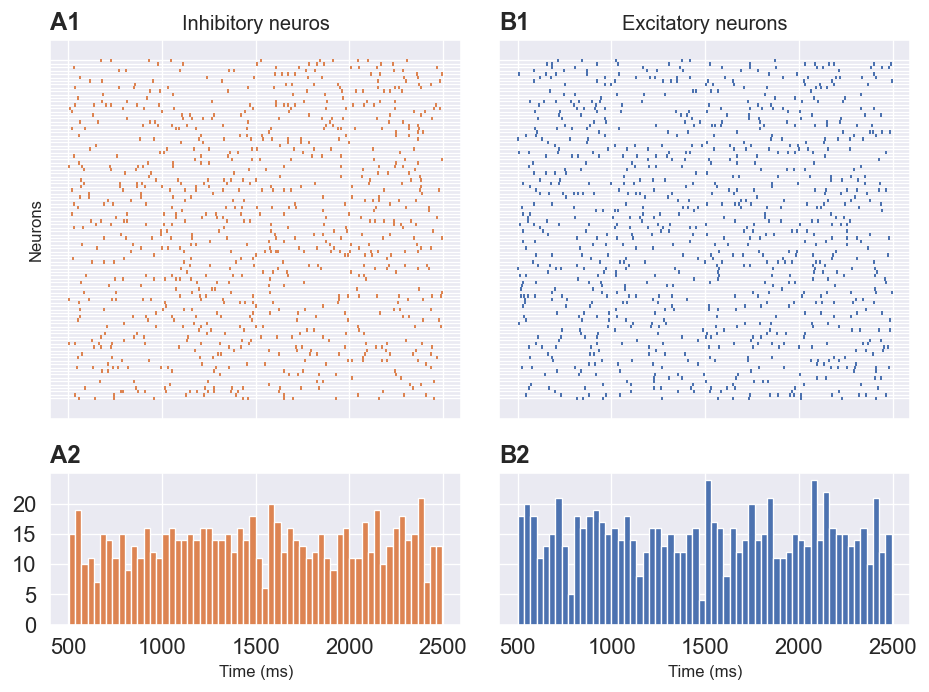

In [21]:
title="ex"
bins=60
in_color = "C1"
ex_color = "C0"
lw = 1
dpi=120

fig, ax = plt.subplots(2, 2, figsize=(8, 6), gridspec_kw={'height_ratios': [.5, 0.2]}, sharex="col", sharey="row", dpi=dpi)

create_rasterplot(spiketrain_I, "In", ax=ax[0, 0], color=in_color, stop=100, fontsize=14, linewidth=lw)
ax[0, 0].set_title("Inhibitory neuros", size=12)
ax[0, 0].set_title("A1", loc="left", fontweight="bold")
ax[0, 0].set_ylabel("Neurons", fontsize=10)

create_rasterplot(spiketrain_E, "Ex", ax=ax[0, 1], stop=100, color=ex_color, fontsize=14, linewidth=lw)
ax[0, 1].set_title("Excitatory neurons", size=12)
ax[0, 1].set_title("B1", loc="left", fontweight="bold")


ax[1, 0].hist(spike_hist_inh, bins=bins,  color=in_color)
ax[1, 0].set_xlabel('Time (ms)', fontsize=10)
ax[1, 0].set_title("A2", loc="left", fontweight="bold")
ax[1, 0].set_yticks(range(0, 25, 5))


# Excitatory hist
ax[1, 1].hist(spike_hist_exc, bins=bins, color=ex_color)
ax[1, 1].set_xlabel('Time (ms)', fontsize=10)
ax[1, 1].set_title("B2", loc="left", fontweight="bold")
ax[1, 1].set_yticks(range(0, 25, 5))



plt.tight_layout()

# Save file
save_path_twopop = Path("./for_thesis/data/raster_plots_2pop")

if SAVE_PLOT:
    # Saving figure
    print(f"Saving to file: {save_path_twopop}.pdf")
    #save_path_twopop.parent.mkdir(parents=True, exist_ok=True)  # Create if it doesnt exist
    plt.savefig(f"{save_path_twopop}.pdf", format="pdf")
    print("File saved.")

In [24]:
helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/embedding/2pop_best_params_embedding_sim_1")

{'hidden_features': 254,
 'num_transforms': 6,
 'num_sumstats': 7,
 'learning_rate': 9.136931444060501e-05}

In [25]:
helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/embedding/2pop_best_params_embedding_sim_0")

{'hidden_features': 152,
 'num_transforms': 6,
 'num_sumstats': 52,
 'learning_rate': 3.5982019447862315e-05}

In [27]:
helper_funcs.load_file("../2pop/sbi/sbi_data/sim_0/simple/2pop_best_params_simple_sim_0")

{'hidden_features': 172,
 'num_transforms': 14,
 'learning_rate': 0.00048074339990466787}

In [28]:
helper_funcs.load_file("../2pop/sbi/sbi_data/sim_1/simple/2pop_best_params_simple_sim_1")

{'hidden_features': 185,
 'num_transforms': 2,
 'learning_rate': 0.00043970830959978843}